In [18]:
#https://www.kaggle.com/datasets/suraj520/rf-signal-data/data

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Data

### Load and Prepare Data

In [49]:
# Load dataset
df = pd.read_csv("logged_data.csv")

# Convert 'Timestamp' to datetime if not already done
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract useful features from the timestamp
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

# Drop the original 'Timestamp' column
df.drop('Timestamp', axis=1, inplace=True)

# Optionally sample a fraction of the data for quick testing
df = df.sample(frac=0.01, random_state=42)  # Adjust frac to the fraction you want


# Handling missing values - drop columns with all missing values and fill others
df.drop(columns=['Air Pressure'], inplace=True)  # Drop column with all missing values
df['I/Q Data'].fillna(method='ffill', inplace=True)  # Forward fill missing values
df['Interference Type'].fillna('None', inplace=True)  # Fill missing categoricals with 'None'


/var/folders/d2/n_5_62n524v01v1vk59vwv0h0000gn/T/ipykernel_4077/35375167.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['I/Q Data'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/d2/n_5_62n524v01v1vk59vwv0h0000gn/T/ipykernel_4077/35375167.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['I/Q Data'].fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/d2/n_5_62n52

### Define Preprocessing Steps

In [50]:
# Define categorical and numerical columns, ensuring 'Weather Condition' is excluded from features
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'Weather Condition']
numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64', 'int32', 'bool'] and col != 'Weather Condition']

# Set up preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


### Split Data and Apply Transformations

In [51]:
# Split data into features and target
X = df.drop('Weather Condition', axis=1)
y = df['Weather Condition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

# Convert sparse matrix to dense
X_train_prepared = X_train_prepared.toarray()
X_test_prepared = X_test_prepared.toarray()

# Encode the target variable
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)


### weather distribution

In [52]:
# Count occurrences of each unique value in the 'Weather Condition' column
weather_counts = df['Weather Condition'].value_counts()

# Display the counts
print(weather_counts)


Weather Condition
Sunny     566
Rainy     543
Cloudy    533
Name: count, dtype: int64


### Preliminary Data Analysis

### Exploratory Data Analysis (EDA)


## Random Forest

In [7]:
# Define the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline that first transforms the data then fits the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier)])

# Fit the model
pipeline.fit(X_train, y_train)


KeyboardInterrupt: 

### Evaluate Model

In [ ]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


### Model Eval

In [ ]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

### Feature Importance and Visualization

In [ ]:
# Get feature importances from the model and display them
feature_names = numerical_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(categorical_cols))
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importance_dict = dict(zip(feature_names, importances))

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(len(feature_importance_dict)), list(feature_importance_dict.values()), align='center')
plt.yticks(range(len(feature_importance_dict)), list(feature_importance_dict.keys()))
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Predicting Weather Conditions')
plt.show()


## NN

### Define and Compile Neural Network Model

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2

# Setup
input_features = X_train_prepared.shape[1]
num_classes = len(np.unique(y_train_encoded))

model = Sequential([
    #layer1
    Dense(256, activation='relu', input_shape=(input_features,), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.05),

    #layer2
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.05),

    #layer3
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.05),

    #prediction layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               2430720   
                                                                 
 batch_normalization_18 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_19 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 128)              

### Model Training

In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Setup callbacks for model saving and early stopping
checkpoint = ModelCheckpoint('best_model_complex.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, verbose=1)

# Train the model with more complexity
history = model.fit(
    X_train_prepared, y_train_encoded,
    epochs=25,  # Increased number of epochs
    batch_size=64,
    validation_data=(X_test_prepared, y_test_encoded),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/25
204/206 [============================>.] - ETA: 0s - loss: 1.6902 - accuracy: 0.5028
Epoch 1: val_accuracy improved from -inf to 0.32765, saving model to best_model_complex.h5
206/206 [==============================] - 6s 29ms/step - loss: 1.6902 - accuracy: 0.5026 - val_loss: 1.7302 - val_accuracy: 0.3276
Epoch 2/25
205/206 [============================>.] - ETA: 0s - loss: 1.1721 - accuracy: 0.6877
Epoch 2: val_accuracy improved from 0.32765 to 0.32856, saving model to best_model_complex.h5
206/206 [==============================] - 6s 29ms/step - loss: 1.1727 - accuracy: 0.6875 - val_loss: 1.8991 - val_accuracy: 0.3286
Epoch 3/25
204/206 [============================>.] - ETA: 0s - loss: 0.9328 - accuracy: 0.7680
Epoch 3: val_accuracy improved from 0.32856 to 0.33313, saving model to best_model_complex.h5
206/206 [==============================] - 6s 29ms/step - loss: 0.9330 - accuracy: 0.7676 - val_loss: 1.8498 - val_accuracy: 0.3331
Epoch 4/25
204/206 [=================

KeyboardInterrupt: 

### eval

103/103 - 0s - loss: 1.7459 - accuracy: 0.3371 - 371ms/epoch - 4ms/step
Test accuracy: 0.3371


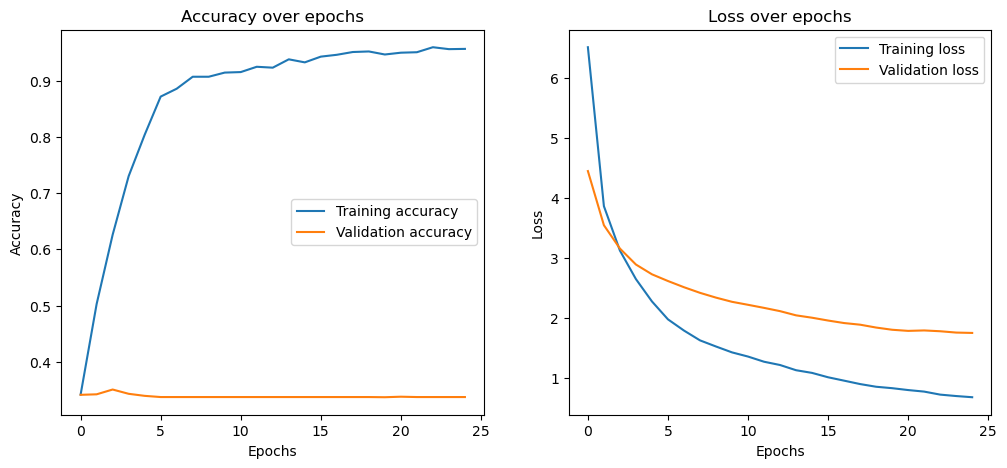

In [36]:
test_loss, test_acc = model.evaluate(X_test_prepared, y_test_encoded, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Plotting the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [61]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf_model = RandomForestClassifier()#n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_prepared, y_train)

# Evaluate the model
rf_predictions = rf_model.predict(X_test_prepared)
print(classification_report(y_test, rf_predictions))


              precision    recall  f1-score   support

      Cloudy       0.27      0.25      0.26       102
       Rainy       0.40      0.29      0.34       119
       Sunny       0.34      0.46      0.40       108

    accuracy                           0.34       329
   macro avg       0.34      0.34      0.33       329
weighted avg       0.34      0.34      0.33       329



In [57]:
#!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/45/6d/8c1d2570a52db6263d855c3ee3daf8f4bdf4a365cd6610772d6fce5fd904/xgboost-2.0.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:0000:0100:01


In [59]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the target variable
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Now train the XGBoost model with the encoded labels
xgb_model.fit(X_train_prepared, y_train_encoded)

# Predict using the trained model
xgb_predictions = xgb_model.predict(X_test_prepared)

# Convert predictions back to original labels for evaluation
xgb_predictions = encoder.inverse_transform(xgb_predictions)

print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

      Cloudy       0.33      0.34      0.33       102
       Rainy       0.35      0.31      0.33       119
       Sunny       0.35      0.38      0.36       108

    accuracy                           0.34       329
   macro avg       0.34      0.34      0.34       329
weighted avg       0.34      0.34      0.34       329



In [60]:
from sklearn.svm import SVC

# Define the model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_model.fit(X_train_prepared, y_train)

# Evaluate the model
svm_predictions = svm_model.predict(X_test_prepared)
print(classification_report(y_test, svm_predictions))


              precision    recall  f1-score   support

      Cloudy       0.28      0.25      0.26       102
       Rainy       0.36      0.26      0.30       119
       Sunny       0.35      0.50      0.41       108

    accuracy                           0.33       329
   macro avg       0.33      0.34      0.33       329
weighted avg       0.33      0.33      0.33       329

